In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from scipy import stats
from modelval import TripModel, network
from modelval.ArbDataGen import arb_w_gen
from modelval import TripNet
import time

% matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

0.0115143308703 0.0104619495657 4.65442765631


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


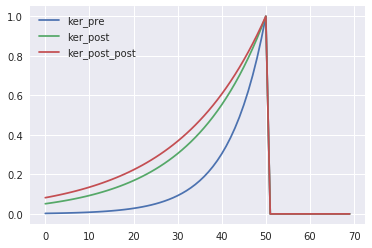

In [3]:
# Load Gerstner's kernel
# Visualize kernel
from modelval.kernel import KernelGen

para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = np.array(para[:4].values)
tau = np.array(para[4:].values)
reso_set = 2
ker_test = KernelGen()
ker_test.trip_model_ker(para, data_name='Hippocampus')

# Generate kernel for TripModel
ker_pre_post_hp, ker_post_pre_hp, ker_post_post_hp, len_ker = TripNet.ker_gen(a, tau, reso_set)
ker_test.kernel_pre = ker_pre_post_hp
ker_test.kernel_post = ker_post_pre_hp
ker_test.kernel_post_post = ker_post_post_hp
ker_test.kernel_scale = np.array([1,1,1])
ker_test.len_kernel = len_ker

plt.plot(ker_test.kernel_pre[150:220]/np.max(ker_test.kernel_pre), label='ker_pre')
plt.plot(ker_test.kernel_post[150:220]/np.max(ker_test.kernel_post), label='ker_post')
plt.plot(ker_test.kernel_post_post[150:220]/np.max(ker_test.kernel_post_post), label='ker_post_post')

plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [4]:
# Generate arbitray spike trains
# Load STDP data
vali_input_tt = np.load('/data/8ptl_vali_spk.npy')
vali_target_tt = np.load('/data/8ptl_vali_target.npy')
vali_ptl = np.load('/data/8ptl_vali_ptl.npy')

In [13]:
# Generate predcition with validation set from the augmented STDP data
STDP_vali_input_ori = vali_input_tt[:int(vali_ptl[0]),:,:]
STDP_vali_input_pre = STDP_vali_input_ori[0,:30000,0]
STDP_vali_input = np.zeros((1,30000,2))
STDP_vali_input[0,:,0] = STDP_vali_input_pre
STDP_vali_input[0,:,1] = STDP_vali_input_pre

In [14]:
STDP_vali_input.shape

(1, 30000, 2)

In [15]:
# Generate prediction with Gerstner's model
loci_track_pre = []
loci_track_post = []
dt_track = []

for i in range(STDP_vali_input.shape[0]):
    loci_pre_STDP = np.where(STDP_vali_input[i,:,0] > 0)[0]
    loci_post_STDP = np.where(STDP_vali_input[i,:,1] > 0)[0]
    dt = np.mean(loci_post_STDP - loci_pre_STDP)
    dt_track.append(dt)
    
    loci_track_pre.append(loci_pre_STDP)
    loci_track_post.append(loci_post_STDP)
    
dt_final = np.hstack(dt_track)

In [17]:
start = time.time()
_, _, dw_AA_STDP = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre, loci_track_post, ifSTDP=1, reso = reso_set)
end = time.time()
print('{a} sec'.format(a=end-start))

0.13187503814697266 sec


In [18]:
# Build the TripNet
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
spk_len = int(data[data['ptl_idx']==1]['train_len'].max() * 1000 / ker_test.reso_kernel)

# ground_truth_init = 1
# toy_data_net2 = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=STDP_vali_input.shape[1])

In [24]:
# Predict
start = time.time()
_, TripNet_pred = arb_w_gen(spk_pairs=STDP_vali_input, spk_len=spk_len, kernel=ker_test, net_type='triplet')
end = time.time()
print('{a} sec'.format(a=end-start))

0.26888346672058105 sec


In [25]:
(a[0] - a[2]) * 60

0.108

In [26]:
TripNet_pred

array([[ 0.108]])

In [27]:
dw_AA_STDP

array([ 0.108])